# Import necessary libraries
SAFEP_parse.py contains all the functions and library calls necessary to run the notebook
# Required libraries:
- numpy
- pandas
- matplotlib
- alchemlyb (pip install git+https://github.com/alchemistry/alchemlyb)
- natsort (for sorting file names)
- glob (for unix-like file paths)



In [2]:
from SAFEP_parse import *
plt.rcParams['figure.dpi'] = 150

In [3]:
path='../'
filename='AFEP2-02.fepout'
fepoutFiles = glob(path+filename)
temperature = 300
RT = 0.00198720650096 * temperature # ca. 0.59kcal/mol
print(f"Will process {len(fepoutFiles)} fepout files.")

Will process 1 fepout files.


# Use the Multistate Bennett Acceptance Ratio estimator

In [4]:
u_nk = namd.extract_u_nk(fepoutFiles, temperature)

# Decorrelate the data using the dE method from alchemlyb
See Shirts and Chodera (2008) for more details

"Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

In [5]:
from alchemlyb.preprocessing import subsampling

method = 'dE'
affix = f'decorrelated_{method}'
#affix = 'unprocessed'

groups = u_nk.groupby('fep-lambda')
decorr = pd.DataFrame([])
for key, group in groups:
    test = subsampling.decorrelate_u_nk(group, method)
    decorr = decorr.append(test)
    
u_nk = decorr

/Users/ezry/opt/anaconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time').duplicated('time').any()
/Users/ezry/opt/anaconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:133: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time', name='').duplicated('time').any()


In [6]:
bar = BAR()
bar.fit(u_nk)

BAR()

# Extract key features from the MBAR fitting and get ΔG
Note: alchemlyb operates in units of kT by default. We multiply by RT to conver to units of kcal/mol.

In [13]:
l, l_mid, f, df, ddf, errors = get_MBAR(bar)
print("Overall free energy",df.cumsum() * RT) #in unit of kcal/mol
print("Errors", errors)

#Overall delta G*_site
print('')
print('')
print(f'\u0394G = {np.round((df.cumsum()*RT)[-1], 3)}\u00B1{np.round(errors[-1], 3)} kcal/mol')

Overall free energy [ 0.66985986  1.44055072  2.29299787  3.28564591  4.36961841  5.38290973
  6.38943547  7.35678066  8.23277745  8.84117321  9.41941157 10.02137446
 10.65306221 11.25963048 11.8728358  12.45315999 13.05506589 13.65710104
 14.26020374 14.80783407]
Errors [0.         0.01971709 0.02881225 0.03900602 0.04822174 0.05732281
 0.06847165 0.08536858 0.09742177 0.11528306 0.11817629 0.11908715
 0.12004902 0.12130059 0.12280991 0.12424513 0.12507285 0.12590285
 0.12661076 0.1273423  0.12852248]


ΔG = 14.808±0.129 kcal/mol


# Plot the change in free energy based on MBAR estimates

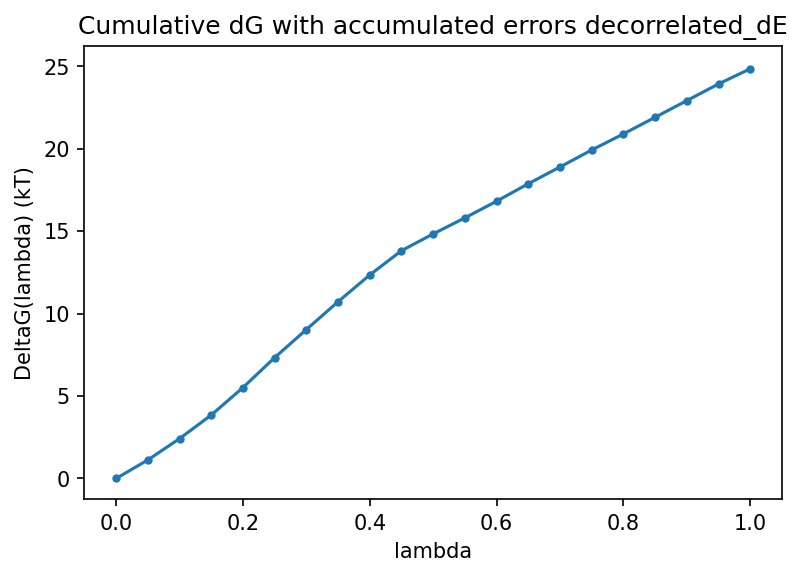

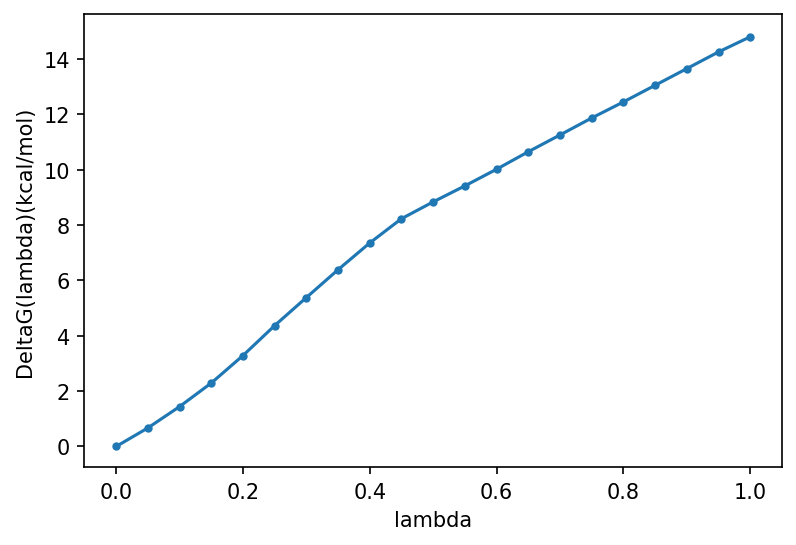

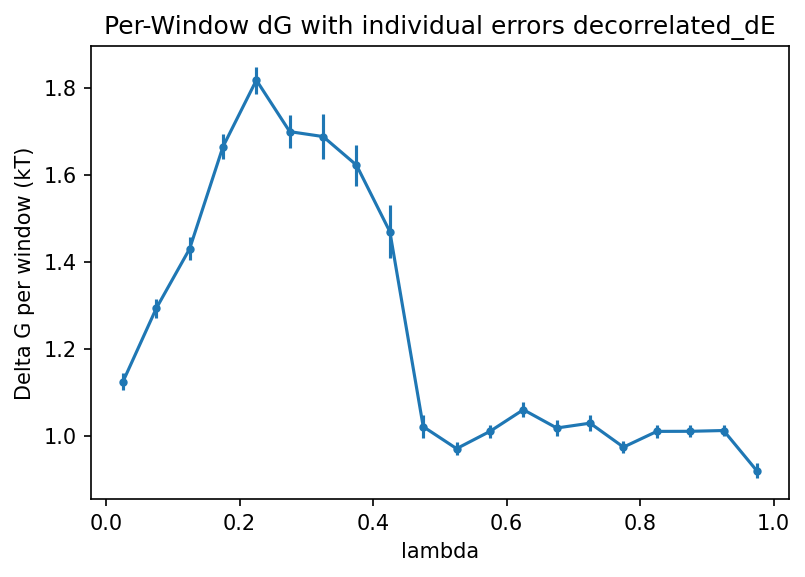

In [14]:
# Cumulative change in kT
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.title(f'Cumulative dG with accumulated errors {affix}')
plt.savefig(f'dG_cumulative_{affix}.png', dpi=600)
plt.show()

# Cumulative change in kcal/mol
plt.errorbar(l, f * RT, yerr=errors*RT, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda)(kcal/mol)')
plt.show()

# Per-window change in kT
plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.title(f'Per-Window dG with individual errors {affix}')
plt.savefig(f'dG_{affix}.png', dpi=600)
plt.show()


# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

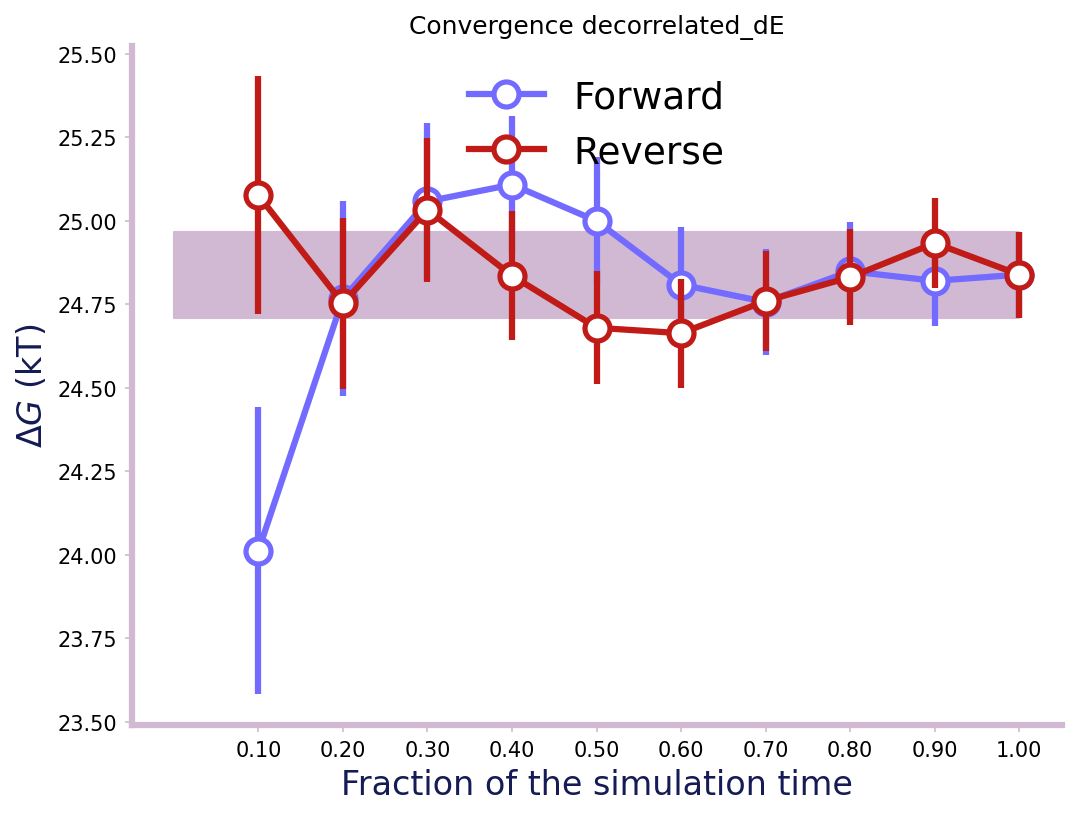

In [15]:
convergence_plot(u_nk, l)
plt.title(f'Convergence {affix}')
plt.savefig(f'convergence_{affix}.png', dpi=600)

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

In [16]:
l, l_mid, dG_f, dG_b = get_EXP(u_nk)

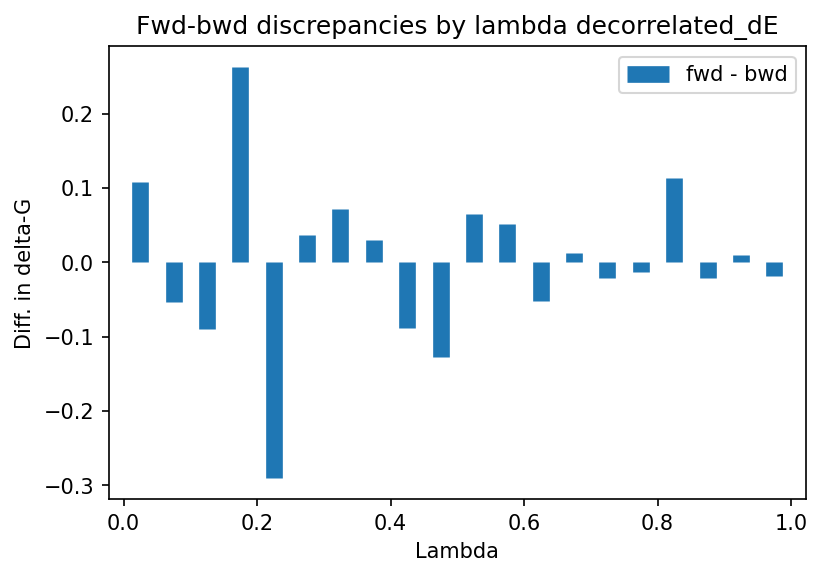

In [17]:
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=8)

plt.legend()
plt.title(f'Fwd-bwd discrepancies by lambda {affix}')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')
plt.savefig(f'discrepancies_{affix}.png', dpi=600)

# The above data should follow a roughly normal distribution centered on 0.

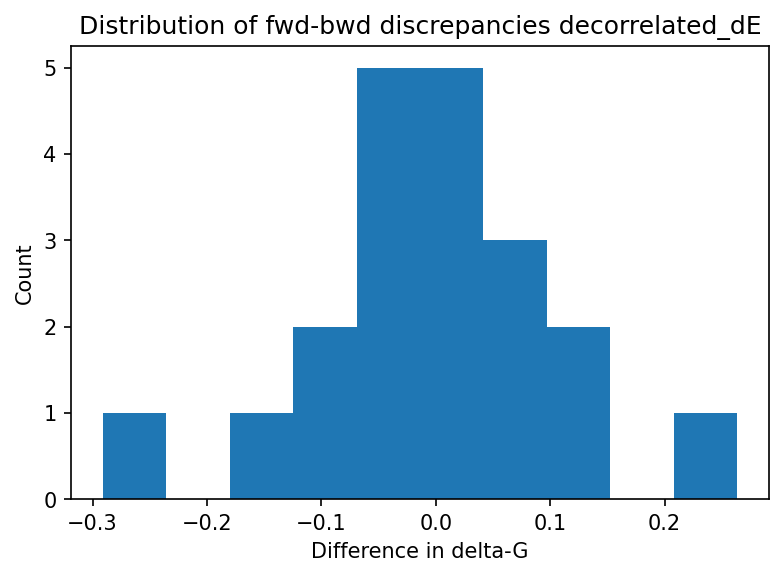

In [18]:
plt.hist(dG_f + np.array(dG_b));
plt.title(f'Distribution of fwd-bwd discrepancies {affix}')
plt.xlabel('Difference in delta-G')
plt.ylabel('Count')
plt.savefig(f'distribution_{affix}.png', dpi=600)